In [1]:
import os
import sys
import torch
import numpy
import tarfile
from io import BytesIO
from torch.utils.data import DataLoader
from typing import Union
from belashovplot import TiledPlot
from itertools import product
from tqdm.notebook import tqdm
sys.path.append(os.path.abspath("../source"))

In [2]:
from dataset import MapsDataset

In [3]:
input_path = os.path.abspath("../data/input")
target_path = os.path.abspath("../data/target")
patches_path = os.path.abspath("../data/patches.tar")

In [4]:
torch.multiprocessing.set_start_method("spawn", force=True)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
print(f"Using: {torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'cpu'}")

Using: NVIDIA GeForce RTX 3060 Ti


# Инициализация набора данных

In [6]:
dataset = MapsDataset(input_path, target_path)
loader = DataLoader(dataset, batch_size=16, shuffle=False, prefetch_factor=4, pin_memory=True, persistent_workers=True, num_workers=6)
image, target = dataset[0]
print(f"Input{tuple(image.shape)} -> Target{tuple(target.shape)}")

Input(3, 640, 640) -> Target(1, 640, 640)


# Функция выделения патчей

In [7]:
def enpatch(image:torch.Tensor, mask:torch.Tensor, patch:tuple[int,int]) -> tuple[torch.Tensor,torch.Tensor]:
    window = [v//2 for v in mask.shape[-2:]]
    pads = [v//2 for v in patch]
    value = torch.max(image, dim=1)[0].unsqueeze(1)
    value = torch.nn.functional.conv2d(value, mask, padding=window, stride=1)
    level = torch.nn.functional.max_pool2d(value, kernel_size=[2*v+1 for v in window], stride=1, padding=window)
    value = torch.where(value==level,1,0)*(level>0)
    indices = torch.nonzero(value.squeeze(1)==1)
    center_b, center_x, center_y = [v+pad for v,pad in zip(indices.movedim(-1,0), [0]+pads)]
    offset_x, offset_y = [torch.arange(-w//2,-w//2+w,device=image.device) for w in patch]
    slice_x, slice_y = center_x.view(-1,1,1)+offset_x.view(1,-1,1), center_y.view(-1,1,1)+offset_y.view(1,1,-1)
    patches = torch.nn.functional.pad(image,[pads[0],pads[0],pads[1],pads[1]])[center_b.view(-1,1,1),:,slice_x,slice_y].movedim(-1,-3)
    return indices, patches

# Выделение вышек на карте

In [8]:
patches = []
with torch.no_grad():
    window = 8
    patch_size = (24,24)
    sigma = 0.3
    mask = sum([v**2 for v in torch.meshgrid(*[torch.linspace(-1,+1,2*window+1)]*2, indexing="ij")])
    mask = torch.exp(-0.5*(mask/sigma)**2).view(1,1,*mask.shape).to(device)

  0%|          | 0/8 [00:00<?, ?it/s]

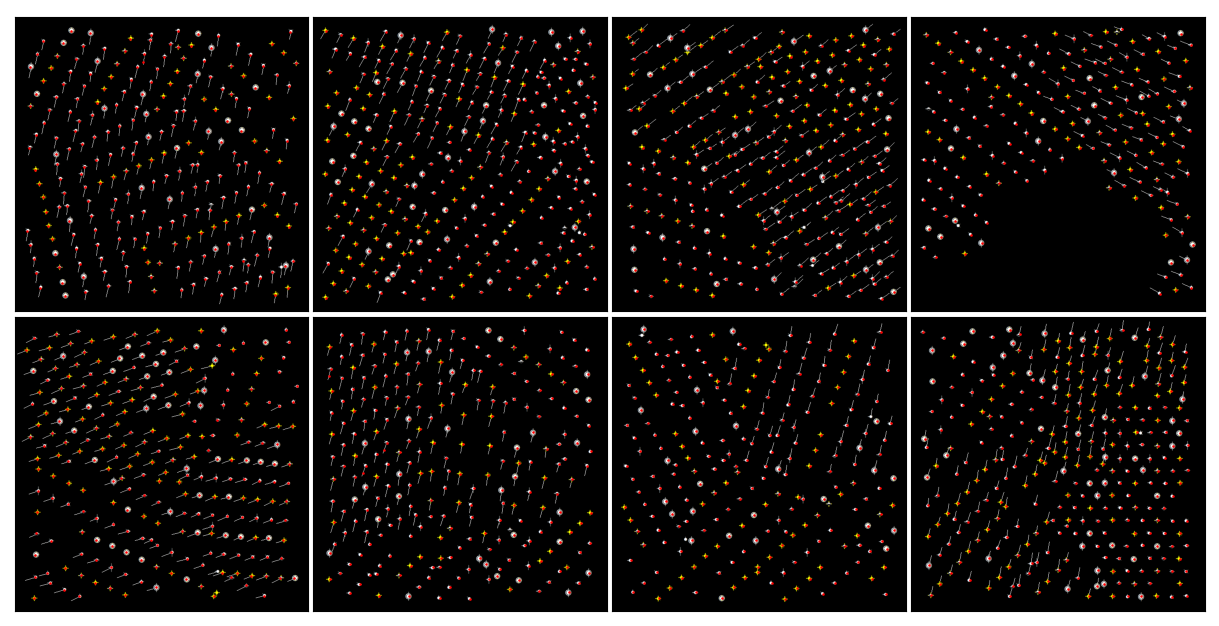

In [9]:
cols, rows = 4,2
plot = TiledPlot(12,None)
plot.pad.graph.vertical(0.05)
plot.pad.graph.horizontal(0.05)
for (row,col), (image,target) in tqdm(zip(product(range(rows),range(cols)),dataset), total=cols*rows):
    axes = plot.axes.add(col,row)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    axes.imshow(image.movedim(0,-1), aspect="auto")
    with torch.no_grad():
        indices, patches_ = [v.cpu() for v in enpatch(image.unsqueeze(0).to(device), mask, patch=patch_size)]
        patches.append(patches_)
    axes.scatter(indices[:,2],indices[:,1],s=0.7,c="red")
patches = torch.concatenate(patches, dim=0)
patches = patches[torch.randperm(patches.shape[0])]
plot.show()

# Пример выделенных патчей

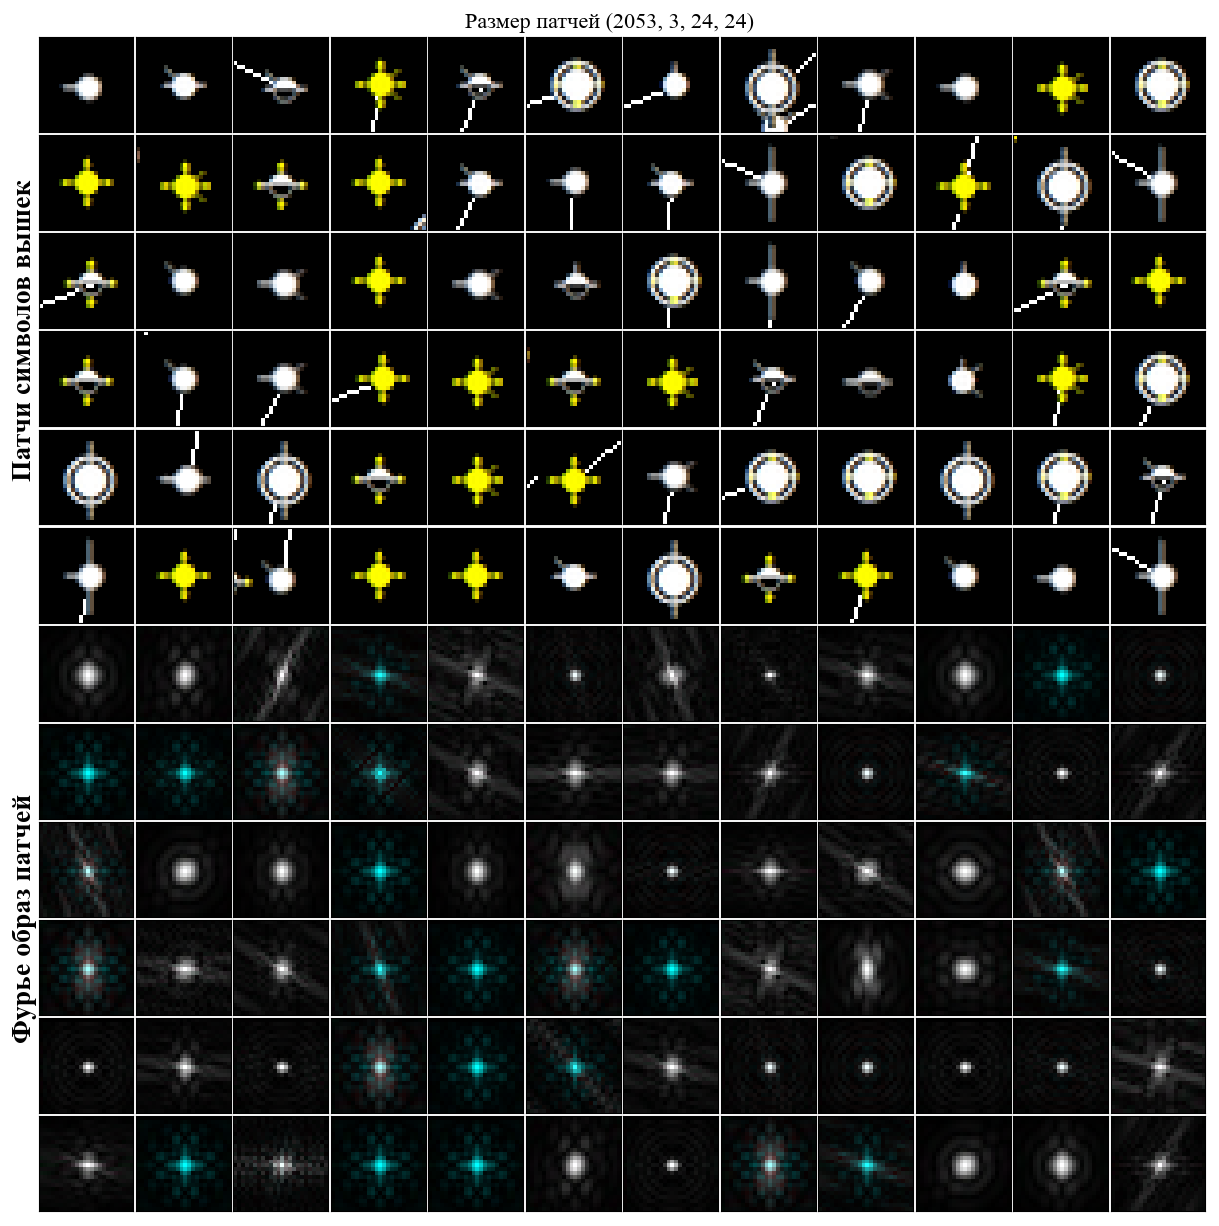

In [10]:
cols, rows = 12,6
plot = TiledPlot(12,None)
plot.pad.graph.vertical(0.025)
plot.pad.graph.horizontal(0.025)
plot.description.row.left("Патчи символов вышек", 0, rows-1)
plot.description.row.left("Фурье образ патчей", rows, 2*rows-1)
plot.description.top(f"Размер патчей {tuple(patches.shape)}")
for patch, (row, col) in zip(patches, product(range(rows),range(cols))):
    axes = plot.axes.add(col,row)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    axes.imshow(patch.movedim(0,-1), aspect="auto")
    axes = plot.axes.add(col,row+rows)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    with torch.no_grad():
        image = torch.fft.fftshift(torch.fft.fft2(patch.to(device))).abs()
        image = (image - image.min()) / (image.max() - image.min())
        image = image.cpu()
    axes.imshow(image.movedim(0,-1), aspect="auto")
plot.show()

# Генерация патчей для всего датасета

In [11]:
if os.path.exists(patches_path): os.remove(patches_path)
with tarfile.open(patches_path, "w") as archive:
    with torch.no_grad():
        total = 0
        with tqdm(loader, desc="Patching") as iterator:
            iterator.set_postfix(patches=total)
            for images, _ in iterator:
                patches_batch = enpatch(images.to(device), mask, (24,24))[1]
                patches_batch = torch.clamp(255*patches_batch, 0., 255.).byte().cpu().numpy()
                for i, patch in enumerate(patches_batch):
                    data = BytesIO()
                    numpy.save(data, patch)
                    data.seek(0)
                    tarinfo = tarfile.TarInfo(name=f"{total+i}.npy")
                    tarinfo.size = data.getbuffer().nbytes
                    archive.addfile(tarinfo, data)
                total += patches_batch.shape[0]
                iterator.set_postfix(patches=total)

Patching:   0%|          | 0/625 [00:00<?, ?it/s]